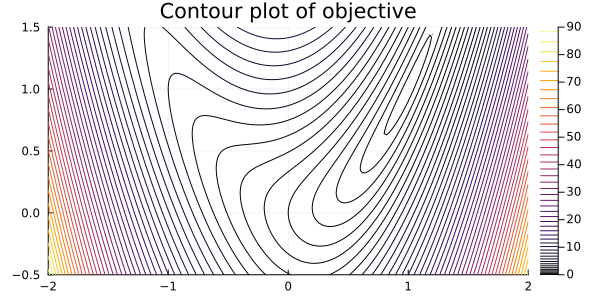

In [1]:
using Plots
gr(size=(600,300))
contour(-2:0.02:2, -0.5:0.02:1.5, (x,y) -> (x - 1)^2 + 4 * (y - x^2)^2, levels=(0:0.2:10).^2)
title!("Contour plot of objective")

In [2]:
using ADNLPModels

nlp = ADNLPModel(
  x -> (x[1] - 1)^2 + 4 * (x[2] - x[1]^2)^2, # function
  [-1.2; 1.0] # starting point
)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  EmptyADbackend,
  EmptyADbackend,
  EmptyADbackend,
  ForwardDiffADHessian,
  EmptyADbackend,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                            

In [3]:
(
  nlp.meta.nvar, # number of variable
  nlp.meta.ncon, # number of constraints
  nlp.meta.lvar, nlp.meta.uvar, # bounds on variables
  nlp.meta.lcon, nlp.meta.ucon, # bounds on constraints
  nlp.meta.x0 # starting point
)

(2, 0, [-Inf, -Inf], [Inf, Inf], Float64[], Float64[], [-1.2, 1.0])

functions from NLPModels to query whether the problem has bounds, equalities, inequalities, etc.

In [4]:
using NLPModels

unconstrained(nlp)

true

In [5]:
x = nlp.meta.x0
obj(nlp, x)

5.614400000000001

In [6]:
grad(nlp, x)

2-element Vector{Float64}:
 -12.847999999999999
  -3.5199999999999996

In [7]:
hess(nlp, x)

2×2 LinearAlgebra.Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}:
 55.12  19.2
 19.2    8.0

In [8]:
using LinearAlgebra

Symmetric(hess(nlp, x), :L)

2×2 Symmetric{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}:
 55.12  19.2
 19.2    8.0

In [9]:
B = Symmetric(hess(nlp, x), :L)
factor = cholesky(B, check=false) # check is false to prevent an error from being thrown.
issuccess(factor)

true

In [10]:
B = -Symmetric(hess(nlp, x), :L) # Since the last one is positive definite, this one shouldn't be
factor = cholesky(B, check=false)
issuccess(factor)

false

In [11]:
ρ = 0.0 # First iteration

B = Symmetric(hess(nlp, x), :L)
factor = cholesky(B + ρ * I, check=false)
while !issuccess(factor)
  ρ = max(1e-8, 10ρ)
  factor = cholesky(B + ρ * I, check=false)
end
d = factor \ -grad(nlp, x)

2-element Vector{Float64}:
  0.4867256637168144
 -0.7281415929203547

In [12]:
α = 1e-2
t = 1.0
fx = obj(nlp, x)
ft = obj(nlp, x + t * d)
slope = dot(grad(nlp, x), d)
while !(ft ≤ fx + t * slope)
  global t *= 0.5 # global is used because we are outside a function
  ft = obj(nlp, x + t * d)
end

SolverCore permet d'avoir en sortie la structure GenericExecutionStats nécessaire à un solveur : 

In [25]:
using SolverCore

function newton(nlp :: AbstractNLPModel; # Only mandatory argument, notice the ;
  max_time :: Float64 = 30.0, # maximum allowed time
  max_iter :: Int = 100 # maximum allowed iterations
  )

  x = copy(nlp.meta.x0) # starting point
  α = 1e-2 # Armijo parameter
  ρ = 0.0

  iter = 0
  t₀ = time()
  Δt = time() - t₀
  status = :unknown
  tired = Δt ≥ max_time > 0 || iter ≥ max_iter > 0
  solved = norm(grad(nlp, x)) ≤ 1e-6
  while !(solved || tired)

    # Computing the direction
    B = Symmetric(hess(nlp, x), :L)
    factor = cholesky(B + ρ * I, check=false)
    while !issuccess(factor)
      ρ = max(1e-8, 10ρ)
      factor = cholesky(B + ρ * I, check=false)
    end
    d = factor \ -grad(nlp, x)

    # Computing the step length
    t = 1.0
    fx = obj(nlp, x)
    ft = obj(nlp, x + t * d)
    slope = dot(grad(nlp, x), d)
    while !(ft ≤ fx + α * t * slope)
      t *= 0.5
      ft = obj(nlp, x + t * d)
    end

    x += t * d

    iter += 1
    Δt = time() - t₀
    tired = Δt ≥ max_time > 0 || iter ≥ max_iter > 0
    solved = norm(grad(nlp, x)) ≤ 1e-6
  end

  if solved
    status = :first_order
  elseif tired
    if Δt ≥ max_time > 0
      status = :max_time
    elseif iter ≥ max_iter > 0
      status = :max_iter
    end
  end

  return GenericExecutionStats(nlp, status=status, solution=x, objective=obj(nlp, x), iter=iter, elapsed_time=Δt)

end

newton (generic function with 1 method)

In [26]:
output = newton(nlp)

println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 7.141610295610004e-18
  primal feasibility: 0.0
  dual feasibility: Inf
  solution: [0.9999999973418803  0.9999999945459112]
  iterations: 9
  elapsed time: 0.0006561279296875


In [27]:
output.solution

2-element Vector{Float64}:
 0.9999999973418803
 0.9999999945459112

In [24]:
SolverCore.show_statuses()

STATUSES:


  :acceptable     => solved to within acceptable tolerances
  :exception      => unhandled exception
  :first_order    => first-order stationary
  :infeasible     => problem may be infeasible
  :max_eval       => maximum number of function evaluations
  :max_iter       => maximum iteration
  :max_time       => maximum elapsed time
  :neg_pred       => negative predicted reduction
  :not_desc       => not a descent direction
  :small_residual => small residual
  :small_step     => step too small
  :stalled        => stalled
  :unbounded      => objective function may be unbounded from below
  :unknown        => unknown
  :user           => user-requested stop


In [28]:
using JSOSolvers

output = lbfgs(nlp)
print(output)

Generic Execution stats
  status: first-order stationary
  objective value: 2.239721910559509e-18
  primal feasibility: 0.0
  dual feasibility: 4.018046284781729e-9
  solution: [0.9999999986742657  0.9999999970013461]
  iterations: 18
  elapsed time: 0.00244903564453125


In [29]:
problems = [
  ADNLPModel(x -> x[1]^2 + 4 * x[2]^2, ones(2)),
  ADNLPModel(x -> (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0]),
  ADNLPModel(x -> x[1]^2 + x[2] - 11 + (x[1] + x[2]^2 - 7)^2, [-1.0; 1.0]),
  ADNLPModel(x -> log(exp(-x[1] - 2x[2]) + exp(x[1] + 2) + exp(2x[2] - 1)), zeros(2))
];

In [30]:
using SolverBenchmark

solvers = Dict(:newton => newton, :lbfgs => lbfgs)
stats = bmark_solvers(solvers, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:         Generic       2       0      first_order   5.9e-01   6.2e-32       Inf   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         Generic       2       0      first_order   5.8e-01   3.7e-21       Inf   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         Generic       2       0         max_iter   5.4e-01  -8.4e+00       Inf   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         Generic       2       0      first_order   5.7e-01   1.4e+00       Inf   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127


┌ Info:         Generic       2       0      first_order   4.8e-05   2.3e-16   5.3e-08   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         Generic       2       0      first_order   7.6e-05   1.4e-17   8.4e-08   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         Generic       2       0      first_order   2.5e-05  -8.4e+00   1.6e-09   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         Generic       2       0      first_order   2.5e-05   1.4e+00   4.2e-09   0.0e+00
└ @ SolverBenchmark /Users/jules/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :newton => 4×39 DataFrame…
  :lbfgs  => 4×39 DataFrame…

In [31]:
@show typeof(stats)
@show keys(stats)

typeof(stats) = Dict{Symbol, DataFrames.DataFrame}
keys(stats) = 

[:newton, :lbfgs]


KeySet for a Dict{Symbol, DataFrames.DataFrame} with 2 entries. Keys:
  :newton
  :lbfgs

In [32]:
cols = [:name, :status, :objective, :elapsed_time, :iter]
pretty_stats(stats[:newton][!, cols])

┌─────────┬─────────────┬───────────┬──────────────┬────────┐
│    name │      status │ objective │ elapsed_time │   iter │
├─────────┼─────────────┼───────────┼──────────────┼────────┤
│ Generic │ first_order │  6.16e-32 │     5.89e-01 │      1 │
│ Generic │ first_order │  3.74e-21 │     5.82e-01 │     21 │
│ Generic │    max_iter │ -8.36e+00 │     5.35e-01 │    100 │
│ Generic │ first_order │  1.43e+00 │     5.70e-01 │      5 │
└─────────┴─────────────┴───────────┴──────────────┴────────┘
